# Federated Learning

In [1]:
import numpy as np
import pandas as pd

In [2]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_seq_items', 20)

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
rng = np.random.default_rng()

## recover the dataset

In [5]:
ratings = pd.read_csv('./datasets/movielens-ratings1M_original.txt', sep=',', 
                      engine='python',
                      header=None, usecols=[0, 1, 2],
                      names=['user', 'item', 'rating'])
num_items = ratings.item.nunique()
num_items, (ratings.item.min(), ratings.item.max())

(3706, (1, 3952))

In [6]:
# eliminate jumps in item id's
id_original = ratings.item.sort_values().unique()
update_dict = {ido:idr for ido, idr in 
               zip(id_original, np.arange(1, num_items+1))}
ratings.item = ratings.item.replace(update_dict)

num_items = ratings.item.nunique()
num_items, (ratings.item.min(), ratings.item.max())

(3706, (1, 3706))

In [7]:
num_users = ratings.user.nunique()
num_users, (ratings.user.min(), ratings.user.max())

(6040, (1, 6040))

All users of the dataset have cast at least 20 votes

In [8]:
min(ratings.groupby('user').item.count())

20

## separate the dataset into training and test

In [9]:
NUM_PIECES = 2
NUM_TRAINING_USERS = 400
NUM_TESTING_USERS = 50
USER = 0; ITEM = 1; RATING = 2

In [10]:
def separate_dataset(df, training, test):
    users_ids = range(1, num_users+1)
    users_rand = rng.choice(users_ids, 
                            training + test, 
                            replace=False)
    training_df = df[df.user.isin(users_rand[:training])]
    test_df = df[df.user.isin(users_rand[training:])]
    
    return training_df, test_df

In [11]:
def set_df_pieces(df, npieces=5):
    bins = list()
    for user in df.user.unique():
        df_aux = df[training_df.user == user]
        bins.extend(pd.cut(df_aux.index, npieces, labels=range(npieces)))
    df.insert(1,'piece', bins)    
    return df

In [12]:
def separate_train(df):
    aux = training_df.groupby('piece')
    X_train = aux.apply(lambda x: x[['user', 'item']].to_numpy())
    y_train = aux.apply(lambda x: x.rating.to_numpy())
    return X_train, y_train

In [13]:
def separate_test(df):
    X_test = df[['user', 'item']].to_numpy()
    y_test = df.rating.to_numpy()
    return X_test, y_test

In [14]:
training_df, test_df = separate_dataset(ratings, NUM_TRAINING_USERS, NUM_TESTING_USERS)
training_df = set_df_pieces(training_df, NUM_PIECES)
X_train, y_train = separate_train(training_df)
X_test, y_test = separate_test(test_df)

In [15]:
import tensorflow as tf

for piece in range(NUM_PIECES):
    X_train[piece] = np.array(X_train[piece]).astype("float32")
X_test = np.array(X_test).astype("float32")
for piece in range(NUM_PIECES):
    y_train[piece] = np.array(y_train[piece]).astype("float32")
y_test = np.array(y_test).astype("float32")

In [16]:
pieces_X_train = list(); pieces_y_train = list()
for i in range(NUM_PIECES):
    pieces_X_train.append(X_train[i])
    pieces_y_train.append(y_train[i])
    X_train_global = np.concatenate(pieces_X_train, axis=0)
    y_train_global = np.concatenate(pieces_y_train, axis=0)
print(X_train_global.shape,y_train_global.shape)

(67017, 2) (67017,)


In [17]:
import matplotlib.pyplot as plt

def plot(h,epochs):
    LOSS = 0; ACCURACY = 1
    training = np.zeros((2,epochs)); testing = np.zeros((2,epochs))
    training[LOSS] = h.history['loss']
    testing[LOSS] = h.history['val_loss']    # validation loss
    training[ACCURACY] = h.history['mae']
    testing[ACCURACY] = h.history['val_mae']  # validation accuracy

    epochs = range(1,epochs+1)
    fig, axs = plt.subplots(1,2, figsize=(17,5))
    for i, label in zip((LOSS, ACCURACY),('loss', 'mae')):   
        axs[i].plot(epochs, training[i], 'b-', label='Training ' + label)
        axs[i].plot(epochs, testing[i], 'y-', label='Test ' + label)
        axs[i].set_title('Training and test ' + label)
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(label)
        axs[i].legend()
        axs[i].grid(True)
    plt.show()

In [18]:
# DEEPMF ML1M 
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, Concatenate
from keras.optimizers import Adam

class RS_Model:
    @staticmethod
    def build():
        latent_dim = 5

        movie_input = Input(shape=[1],name='movie-input')
        movie_embedding = Embedding(num_items + 1, latent_dim, name='movie-embedding')(movie_input)
        movie_vec = Flatten(name='movie-flatten')(movie_embedding)

        user_input = Input(shape=[1],name='user-input')
        user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
        user_vec = Flatten(name='user-flatten')(user_embedding)

        concatenate = Concatenate(axis=1)([movie_vec, user_vec])
        mlp = Dense(5, activation="relu")(concatenate)
        dropout = Dropout(0.4)(mlp)
        output = Dense(1, activation="relu")(dropout)
        model = Model([user_input, movie_input], output)
        return model

Epoch 1/30
524/524 [==============================] - 2s 3ms/step - loss: 5.3794 - mae: 1.9180 - val_loss: 3.6406 - val_mae: 1.6801
Epoch 2/30
524/524 [==============================] - 1s 2ms/step - loss: 2.1845 - mae: 1.1837 - val_loss: 3.1010 - val_mae: 1.5406
Epoch 3/30
524/524 [==============================] - 1s 3ms/step - loss: 2.0085 - mae: 1.1348 - val_loss: 2.6738 - val_mae: 1.4196
Epoch 4/30
524/524 [==============================] - 1s 3ms/step - loss: 1.8472 - mae: 1.0891 - val_loss: 2.3423 - val_mae: 1.3183
Epoch 5/30
524/524 [==============================] - 1s 2ms/step - loss: 1.6742 - mae: 1.0383 - val_loss: 2.0511 - val_mae: 1.2268
Epoch 6/30
524/524 [==============================] - 1s 3ms/step - loss: 1.5145 - mae: 0.9870 - val_loss: 1.7328 - val_mae: 1.1187
Epoch 7/30
524/524 [==============================] - 1s 2ms/step - loss: 1.3572 - mae: 0.9357 - val_loss: 1.5541 - val_mae: 1.0554
Epoch 8/30
524/524 [==============================] - 1s 3ms/step - loss: 1.

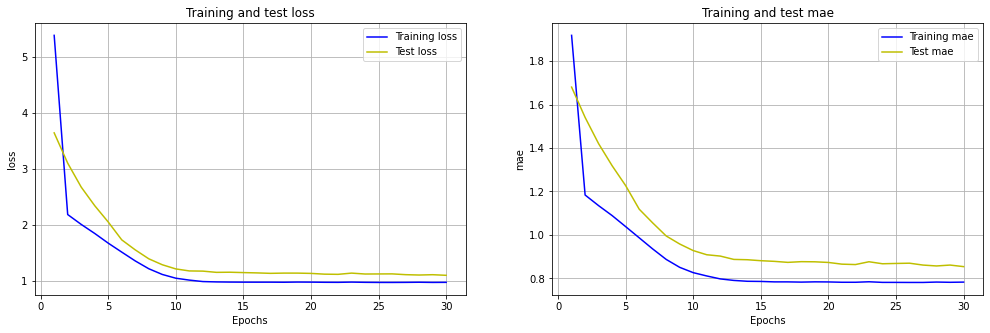

In [25]:
rs_instance = RS_Model()
global_model = rs_instance.build()
global_model.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
EPOCHS = 30; 
history = global_model.fit([X_train_global[:,USER],X_train_global[:,ITEM]],y_train_global, 
                            validation_data=([X_test[:,USER],X_test[:,ITEM]], y_test), 
                            epochs=EPOCHS, batch_size=128, verbose=1)
plot(history,EPOCHS)

In [24]:
print("pasa")
rs_instance = RS_Model()
global_model = rs_instance.build()
global_model.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
EPOCHS = 8; USER = 0; ITEM = 1
for i in range(6500):
    for piece in range(NUM_PIECES):
        global_model.train_on_batch([X_train[piece][:,USER],X_train[piece][:,ITEM]],y_train[piece], 
                                reset_metrics=True)
    if (i%100 == 0):
        global_model.evaluate([X_test[:,USER],X_test[:,ITEM]],y_test,verbose=1)

pasa
353/353 [==============================] - 0s 1ms/step - loss: 1.1799 - mae: 0.8599


In [21]:
training_users = training_df['user'].unique()
local_data = list()
for i,tu in enumerate(training_users):
    for s in range(NUM_PIECES):
        df = training_df.query("user==" + str(tu) + " and piece==" + str(s))
        X = df[['user','item','rating']]
        local_data.append(X)

In [22]:
def weight_scalling_factor(client, weight):
    global_count = len(training_df) # number of total samples
    # get the total number of data points held by a client
    local_count = 0
    for shard in range(NUM_PIECES):
        local_count += len(local_data[client*NUM_PIECES + shard]) # number of local samples
    scalar = local_count/global_count
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final


def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)        
    return avg_grad

In [23]:
#initialize global model
rs_instance = RS_Model()
global_model = rs_instance.build()
global_model.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')

federated_loops = 60
#commence global training loop
for current_loop in range(federated_loops):
    print(federated_loops-current_loop)            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()
    
    #loop through each client and create new local model
    for client in range(len(training_users)):
        rs_local = RS_Model()
        local_model = rs_local.build()
        local_model.compile(optimizer='adam', metrics=['mae'], loss='mean_squared_error')
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        #fit local model with client's data
        for shard in range(NUM_PIECES):
            index = client*NUM_PIECES + shard
            for i in range(10):
                local_model.train_on_batch([np.array(local_data[index]['user']), np.array(local_data[index]['item'])],
                                             np.array(local_data[index]['rating']), reset_metrics=True)
        if (client%100 == 0):
            print("Remaining " + str(len(training_users)-client) + " clients to finish, loop " + str(current_loop))
            local_model.evaluate([X_test[:,USER],X_test[:,ITEM]],y_test,verbose=1)
        #scale the model weights and add to list
        scaled_weights = weight_scalling_factor(client, local_model.get_weights())
        scaled_local_weight_list.append(scaled_weights)
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    print()
    global_model.set_weights(average_weights)
    global_model.evaluate([X_test[:,USER],X_test[:,ITEM]],y_test,verbose=1)
    print("Remaining " + str(len(training_users)-client) + " clients to finish, loop " + str(current_loop))


60
Remaining 400 clients to finish, loop 0
353/353 [==============================] - 0s 1ms/step - loss: 13.1404 - mae: 3.4374
Remaining 200 clients to finish, loop 0
353/353 [==============================] - 0s 1ms/step - loss: 13.1382 - mae: 3.4371
Remaining 100 clients to finish, loop 0
353/353 [==============================] - 1s 1ms/step - loss: 13.1566 - mae: 3.4397

353/353 [==============================] - 1s 1ms/step - loss: 13.1293 - mae: 3.4358
Remaining 1 clients to finish, loop 0
59
Remaining 400 clients to finish, loop 1
353/353 [==============================] - 1s 1ms/step - loss: 12.7824 - mae: 3.3852
Remaining 300 clients to finish, loop 1
353/353 [==============================] - 1s 1ms/step - loss: 12.7856 - mae: 3.3858
Remaining 200 clients to finish, loop 1
353/353 [==============================] - 1s 1ms/step - loss: 12.7849 - mae: 3.3856
Remaining 100 clients to finish, loop 1
353/353 [==============================] - 1s 1ms/step - loss: 12.8078 - mae: 3.

353/353 [==============================] - 0s 1ms/step - loss: 6.9767 - mae: 2.3965

353/353 [==============================] - 1s 2ms/step - loss: 6.9192 - mae: 2.3858
Remaining 1 clients to finish, loop 13
46
Remaining 400 clients to finish, loop 14
353/353 [==============================] - 1s 2ms/step - loss: 6.4077 - mae: 2.2894
Remaining 300 clients to finish, loop 14
353/353 [==============================] - 0s 1ms/step - loss: 6.4166 - mae: 2.2913
Remaining 200 clients to finish, loop 14
353/353 [==============================] - 0s 1ms/step - loss: 6.4171 - mae: 2.2913
Remaining 100 clients to finish, loop 14
353/353 [==============================] - 0s 1ms/step - loss: 6.4432 - mae: 2.2963

353/353 [==============================] - 0s 1ms/step - loss: 6.3847 - mae: 2.2850
Remaining 1 clients to finish, loop 14
45
Remaining 400 clients to finish, loop 15
353/353 [==============================] - 0s 1ms/step - loss: 5.8770 - mae: 2.1859
Remaining 300 clients to finish, loop

353/353 [==============================] - 0s 1ms/step - loss: 1.2056 - mae: 0.9102
Remaining 300 clients to finish, loop 40
353/353 [==============================] - 0s 1ms/step - loss: 1.2528 - mae: 0.9328
Remaining 200 clients to finish, loop 40
353/353 [==============================] - 1s 1ms/step - loss: 1.2482 - mae: 0.9313
Remaining 100 clients to finish, loop 40
353/353 [==============================] - 0s 1ms/step - loss: 1.3291 - mae: 0.9665

353/353 [==============================] - 0s 1ms/step - loss: 1.2783 - mae: 0.9450
Remaining 1 clients to finish, loop 40
19
Remaining 400 clients to finish, loop 41
353/353 [==============================] - 0s 1ms/step - loss: 1.2015 - mae: 0.9085
Remaining 300 clients to finish, loop 41
353/353 [==============================] - 0s 1ms/step - loss: 1.2657 - mae: 0.9391
Remaining 200 clients to finish, loop 41
353/353 [==============================] - 0s 998us/step - loss: 1.2258 - mae: 0.9209
Remaining 100 clients to finish, loop